# Assignment-1, Task 1.1

## Importing used libraries

In [76]:
import numpy as np
import scanpy as sc
import seaborn as sns
import pandas as pd
from scipy.stats import median_abs_deviation
from matplotlib import pyplot as plt

sc.settings.verbosity = 0
sc.settings.set_figure_params(
    dpi=80,
    facecolor="white",
    frameon=False,
)

In [2]:
adata = sc.read_h5ad('dataset.h5ad')
adata.var_names_make_unique()

In [9]:
gene_names = pd.read_csv('gene_names.csv', header=None)
adata.var_names = gene_names[0].values[:adata.shape[1]]

## Quality Control

In [11]:
adata.var["mt"] = adata.var_names.str.startswith("MT-")
adata.var["ribo"] = adata.var_names.str.startswith(("RPS", "RPL"))
adata.var["hb"] = adata.var_names.str.contains(r"^HB(?!P)")

sc.pp.calculate_qc_metrics(
    adata, qc_vars=["mt", "ribo", "hb"], inplace=True, percent_top=[20], log1p=True
)

adata.var

,mt,ribo,hb,n_cells_by_counts,mean_counts,log1p_mean_counts,pct_dropout_by_counts,total_counts,log1p_total_counts
0,False,False,False,338,0.021443,0.021216,96.849072,230.013763,5.442477
LINC00115,False,False,False,307,0.019796,0.019602,97.138063,212.348618,5.362927
FAM41C,False,False,False,9,0.000604,0.000604,99.916100,6.484262,2.012802
SAMD11,False,False,False,2554,0.184793,0.169568,76.190920,1982.274658,7.592505
NOC2L,False,False,False,251,0.016110,0.015981,97.660110,172.809189,5.157958
...,...,...,...,...,...,...,...,...,...
MCM3AP,False,False,False,1296,0.089194,0.085438,87.918337,956.783997,6.864622
YBEY,False,False,False,1066,0.071473,0.069034,90.062459,766.692322,6.643389
PCNT,False,False,False,2741,0.213917,0.193853,74.447655,2294.692383,7.738790
DIP2A,False,False,False,682,0.098202,0.093675,93.642211,1053.418213,6.960744


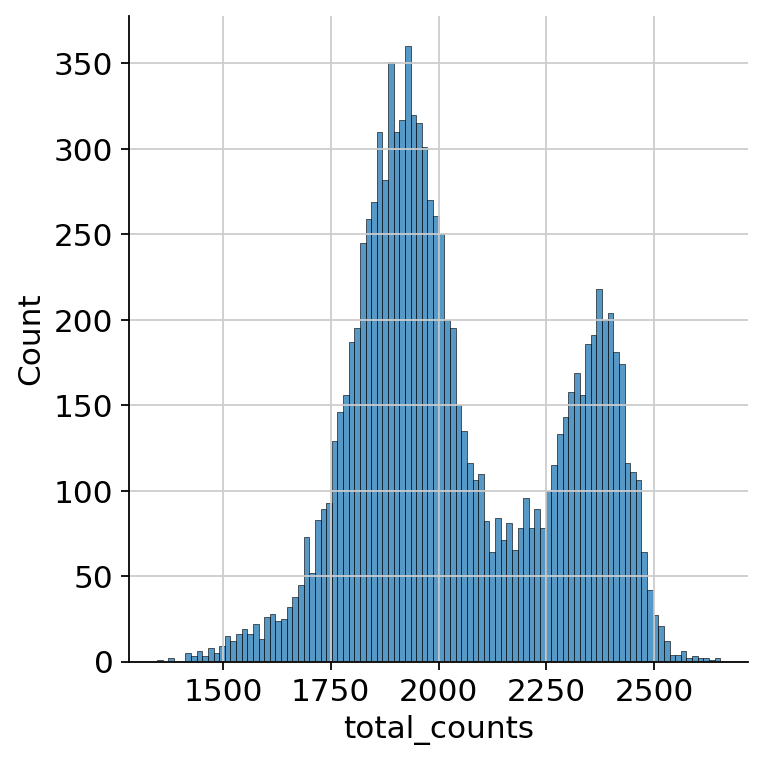

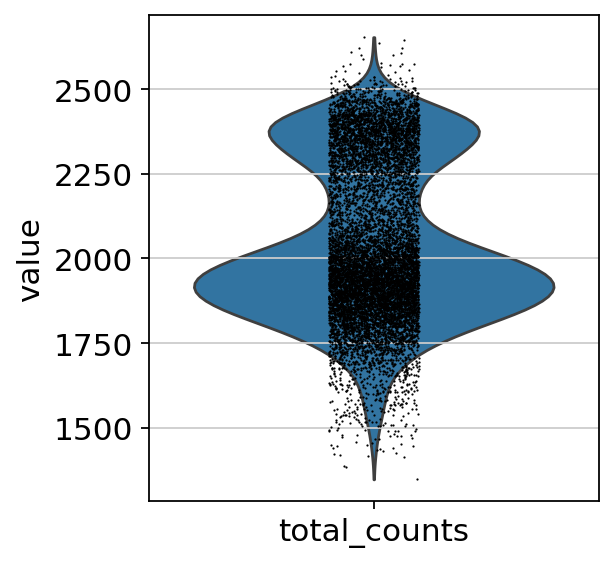

In [12]:
p1 = sns.displot(adata.obs["total_counts"], bins=100, kde=False)
sc.pl.violin(adata, 'total_counts')

In [13]:
def is_outlier(adata, metric: str, nmads: int):
    M = adata.obs[metric]
    outlier = (M < np.median(M) - nmads * median_abs_deviation(M)) | (
        np.median(M) + nmads * median_abs_deviation(M) < M
    )
    return outlier

adata.obs["outlier"] = (
    is_outlier(adata, "log1p_total_counts", 5)
    | is_outlier(adata, "log1p_n_genes_by_counts", 5)
    | is_outlier(adata, "pct_counts_in_top_20_genes", 5)
)

adata.obs["mt_outlier"] = is_outlier(adata, "pct_counts_mt", 3) | (
    adata.obs["pct_counts_mt"] > 8
)

print(f"Total number of cells: {adata.n_obs}")
adata = adata[(~adata.obs.outlier) & (~adata.obs.mt_outlier)].copy()

print(f"Number of cells after filtering of low quality cells: {adata.n_obs}")

Total number of cells: 10727
Number of cells after filtering of low quality cells: 10727


This is clear indidication that cell data was already filtered

In [14]:
sc.pp.filter_cells(adata, min_genes=100)
sc.pp.filter_genes(adata, min_cells=3)

adata = adata[adata.obs['n_genes_by_counts'] > 200, :]
adata = adata[adata.obs['total_counts'] < 25000, :]

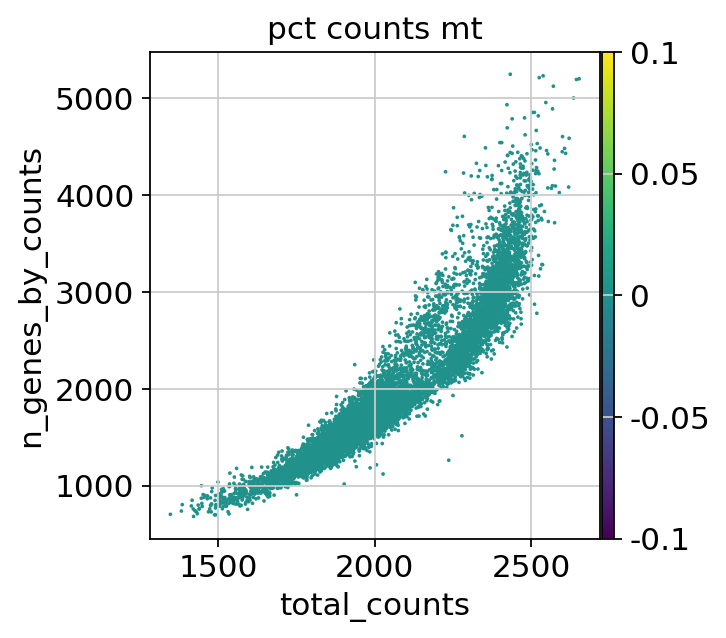

In [15]:
p1 = sc.pl.scatter(adata, "total_counts", "n_genes_by_counts", color="pct_counts_mt")

## Normalization

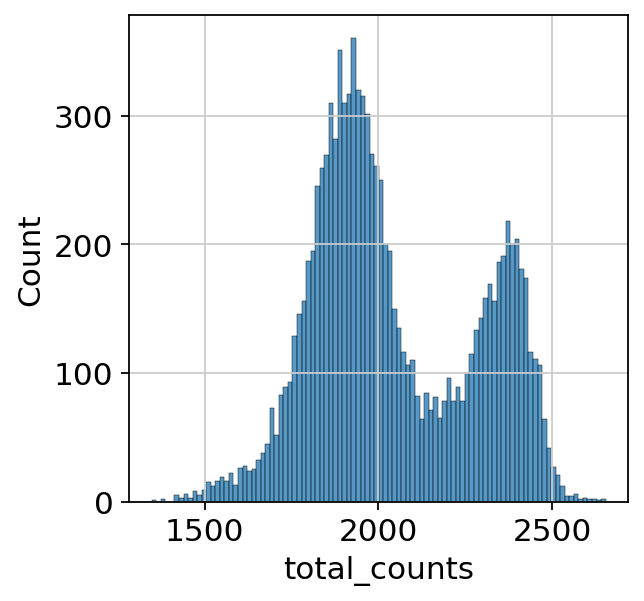

In [16]:
p1 = sns.histplot(adata.obs["total_counts"], bins=100, kde=False)

In [17]:
scales_counts = sc.pp.normalize_total(adata, target_sum=None, inplace=False)
adata.layers["counts"] = adata.X.copy()
adata.layers["log1p_norm"] = sc.pp.log1p(scales_counts["X"], copy=True)

/home/sachida/Documents/courses/cs637/assignment1/.venv/lib/python3.11/site-packages/scanpy/preprocessing/_normalization.py:207: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


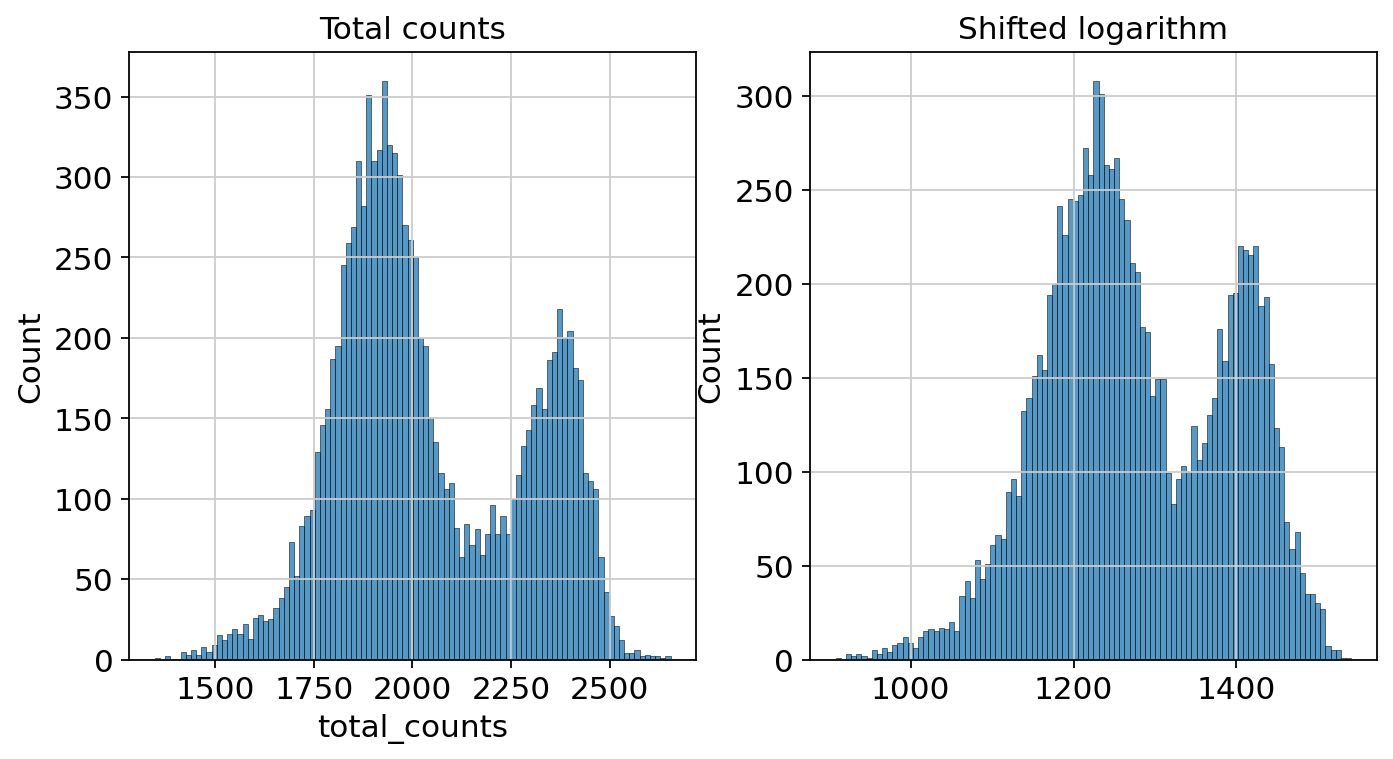

In [18]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
p1 = sns.histplot(adata.obs["total_counts"], bins=100, kde=False, ax=axes[0])
axes[0].set_title("Total counts")
p2 = sns.histplot(adata.layers["log1p_norm"].sum(1), bins=100, kde=False, ax=axes[1])
axes[1].set_title("Shifted logarithm")
plt.show()

## Feature Selection

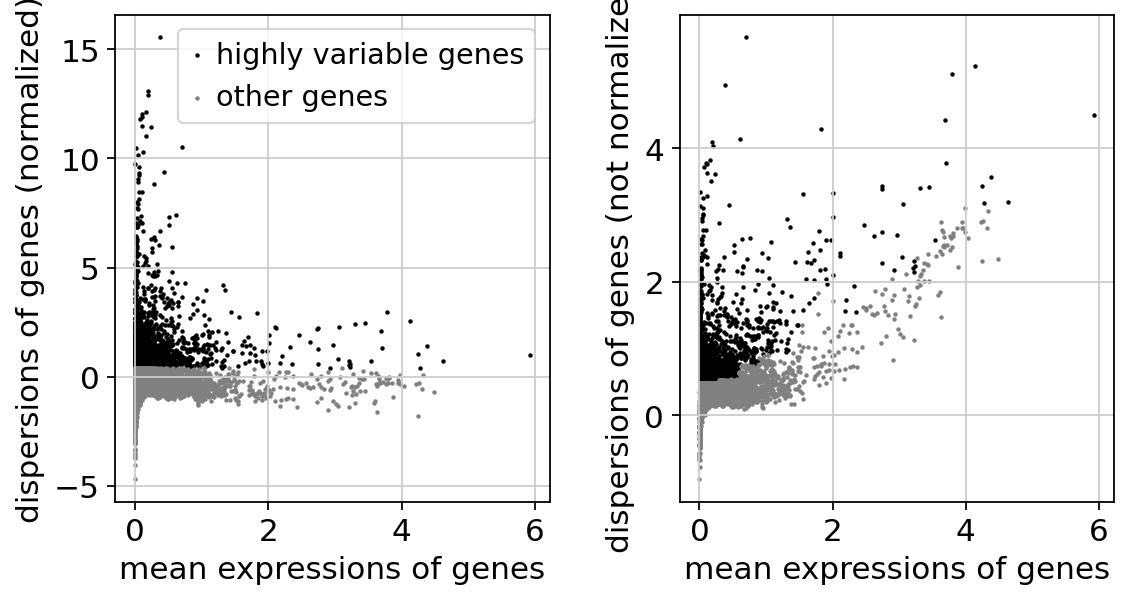

In [19]:
sc.pp.highly_variable_genes(adata, n_top_genes=2000)
sc.pl.highly_variable_genes(adata)

In [72]:
# rcb.logger.setLevel(logging.ERROR)
# ro.pandas2ri.activate()
# anndata2ri.activate()
# %reload_ext rpy2.ipython

In [73]:
# %%R
# library(scry)

In [74]:
# ro.globalenv["adata_X"] = adata

In [75]:
# %%R
# sce = devianceFeatureSelection(adt, assay="X")

# Dimention Reduction

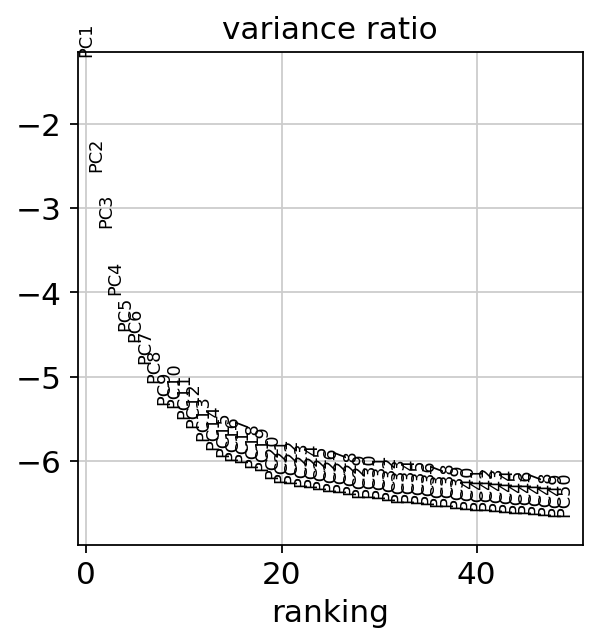

In [24]:
sc.tl.pca(adata)
sc.pl.pca_variance_ratio(adata, n_pcs=50, log=True)

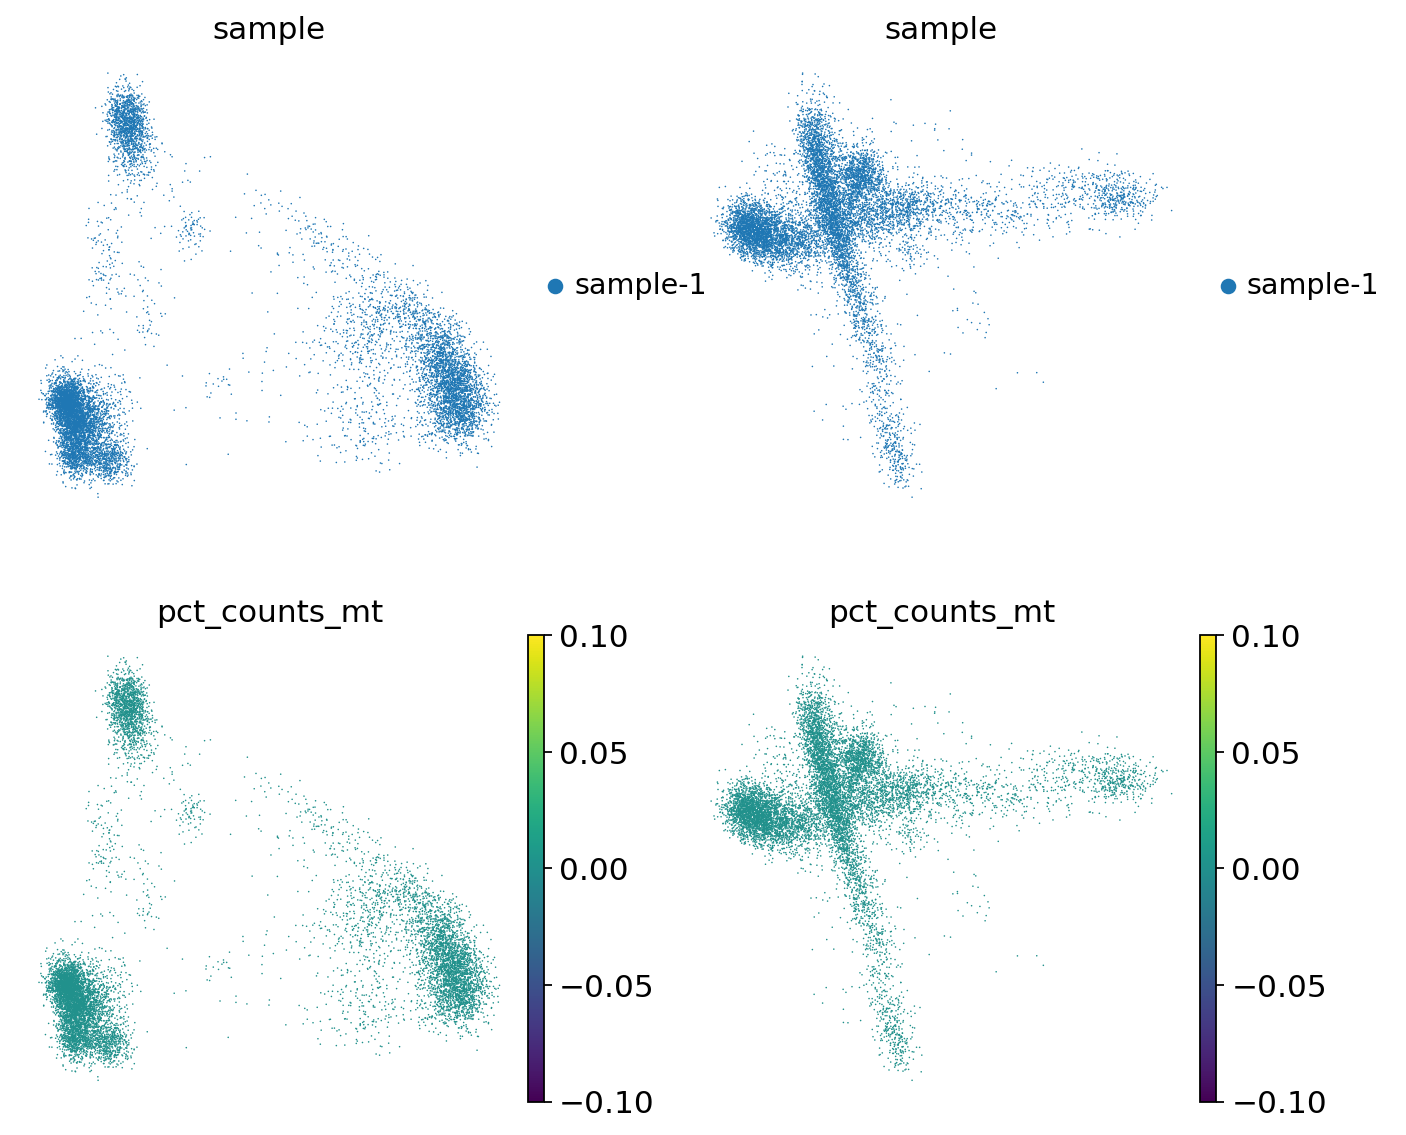

In [27]:
adata.obs["sample"] = "sample-1"
sc.pl.pca(
    adata,
    color=["sample", "sample", "pct_counts_mt", "pct_counts_mt"],
    dimensions=[(0, 1), (2, 3), (0, 1), (2, 3)],
    ncols=2,
    size=2,
)

## Nearest Neighbor Graph Construction

In [28]:
sc.pp.neighbors(adata)
sc.tl.umap(adata)

/home/sachida/Documents/courses/cs637/assignment1/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


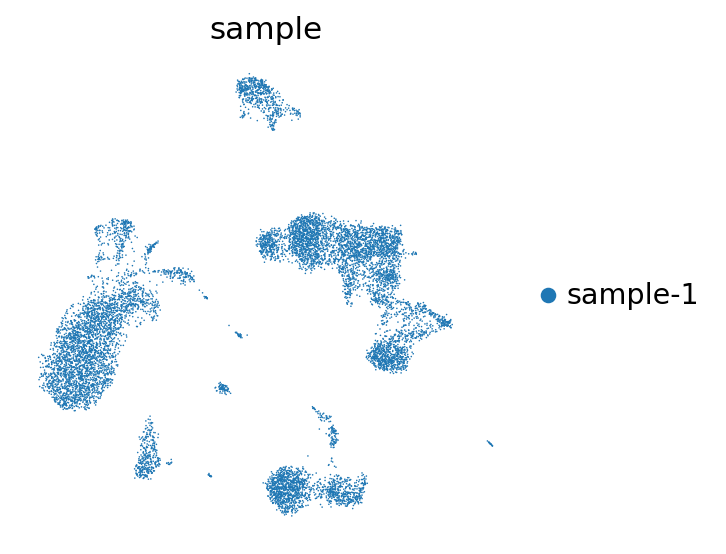

In [29]:
sc.pl.umap(
    adata,
    color="sample",
    size=2,
)

## Clustering

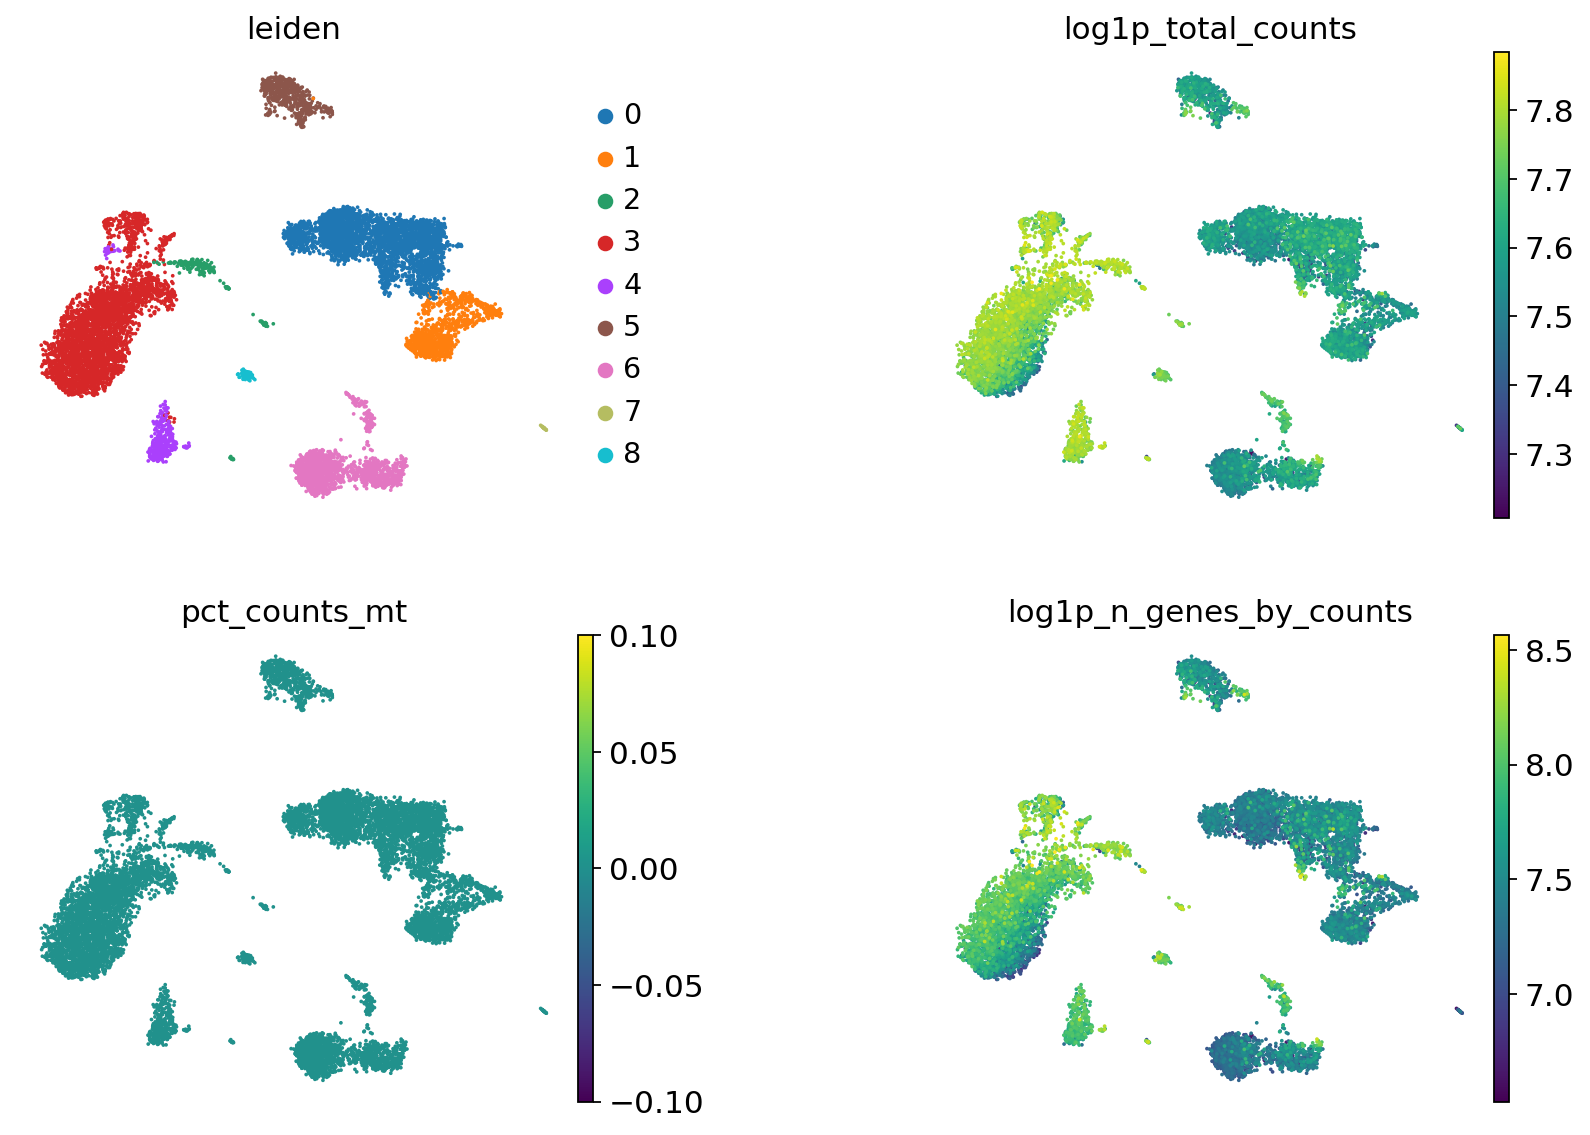

In [49]:
sc.tl.leiden(adata, flavor="igraph", n_iterations=2, resolution=0.0895)

sc.pl.umap(
    adata,
    color=["leiden", "log1p_total_counts", "pct_counts_mt", "log1p_n_genes_by_counts"],
    wspace=0.5,
    ncols=2,
)

df = pd.DataFrame({
    'Id': adata.obs.index,
    'Label': adata.obs['leiden'].astype(int)
})

df.to_csv('solution.csv', index=False)

## Annotations

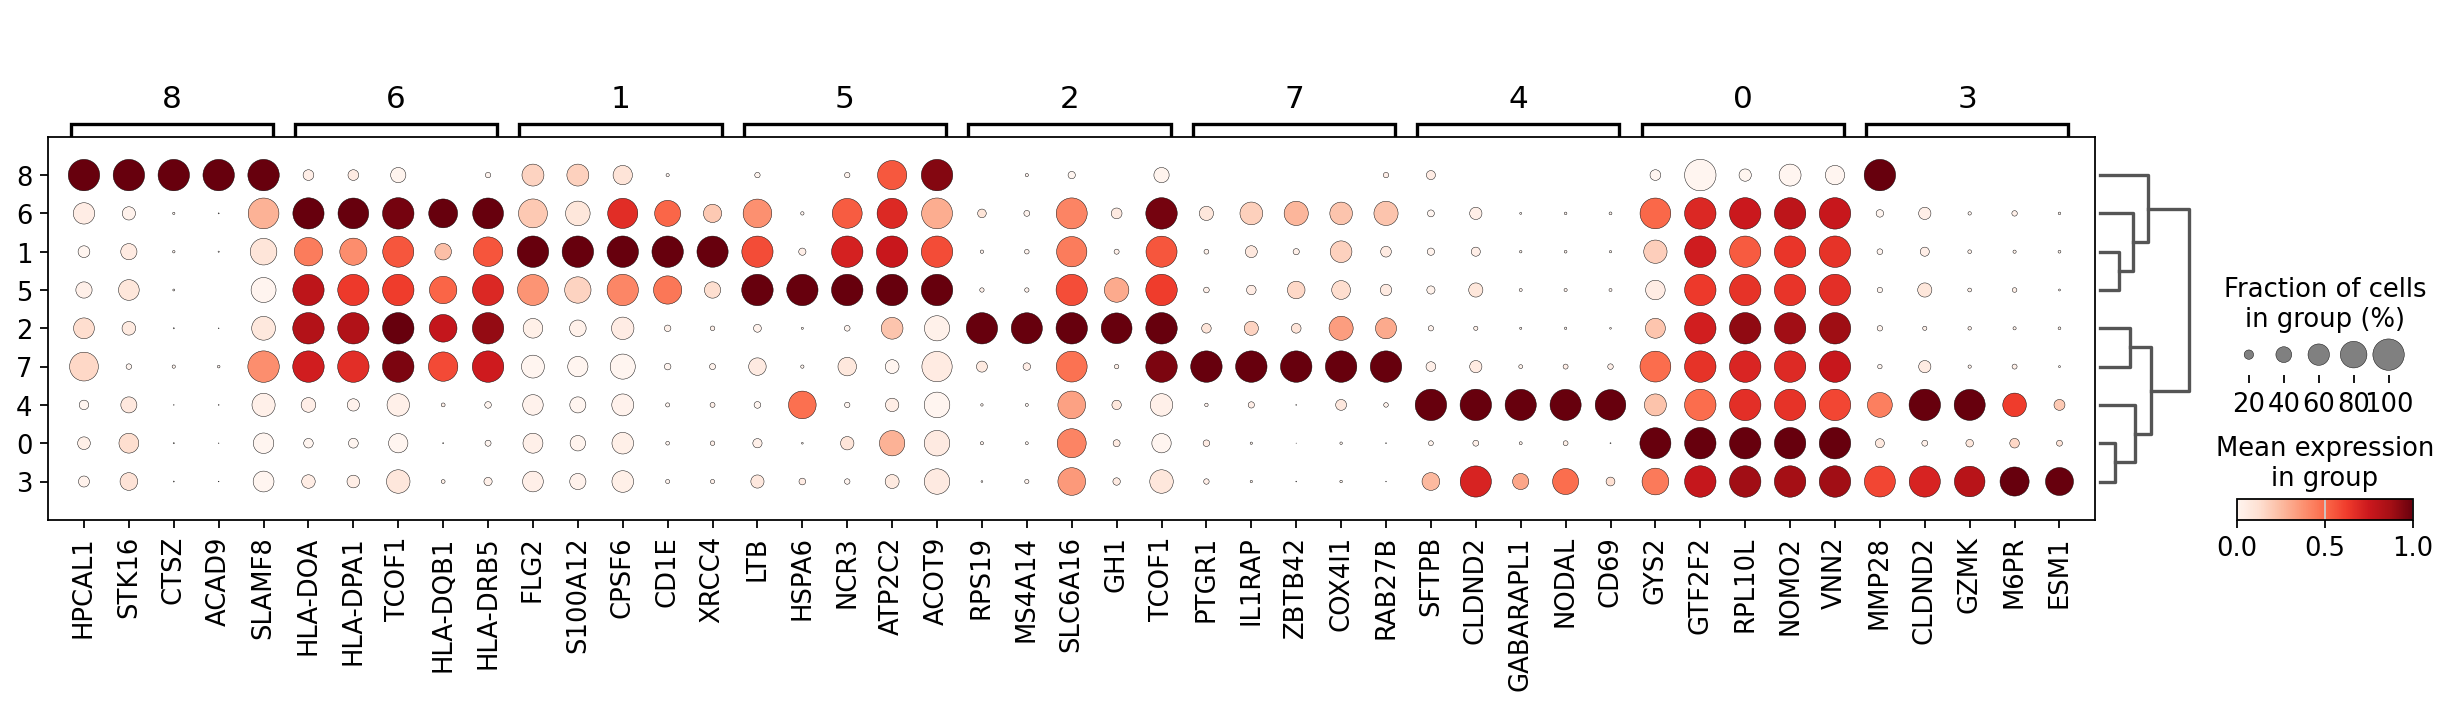

In [34]:
sc.tl.rank_genes_groups(
    adata,
    groupby="leiden",
    method="wilcoxon",
    key_added="rgg_leiden"
)
sc.pl.rank_genes_groups_dotplot(
    adata, groupby="leiden", standard_scale="var", n_genes=5, key="rgg_leiden"
)

In [46]:
gene_of_interest = ["HBD", "CD3D", "CD79A", "NKG7", "CD3", "CD4", "CD8", "CD197"]

missing_genes = [gene for gene in gene_of_interest if gene not in adata.var_names]
print("Missing genes:", missing_genes)

Missing genes: ['HBD', 'CD3', 'CD8', 'CD197']


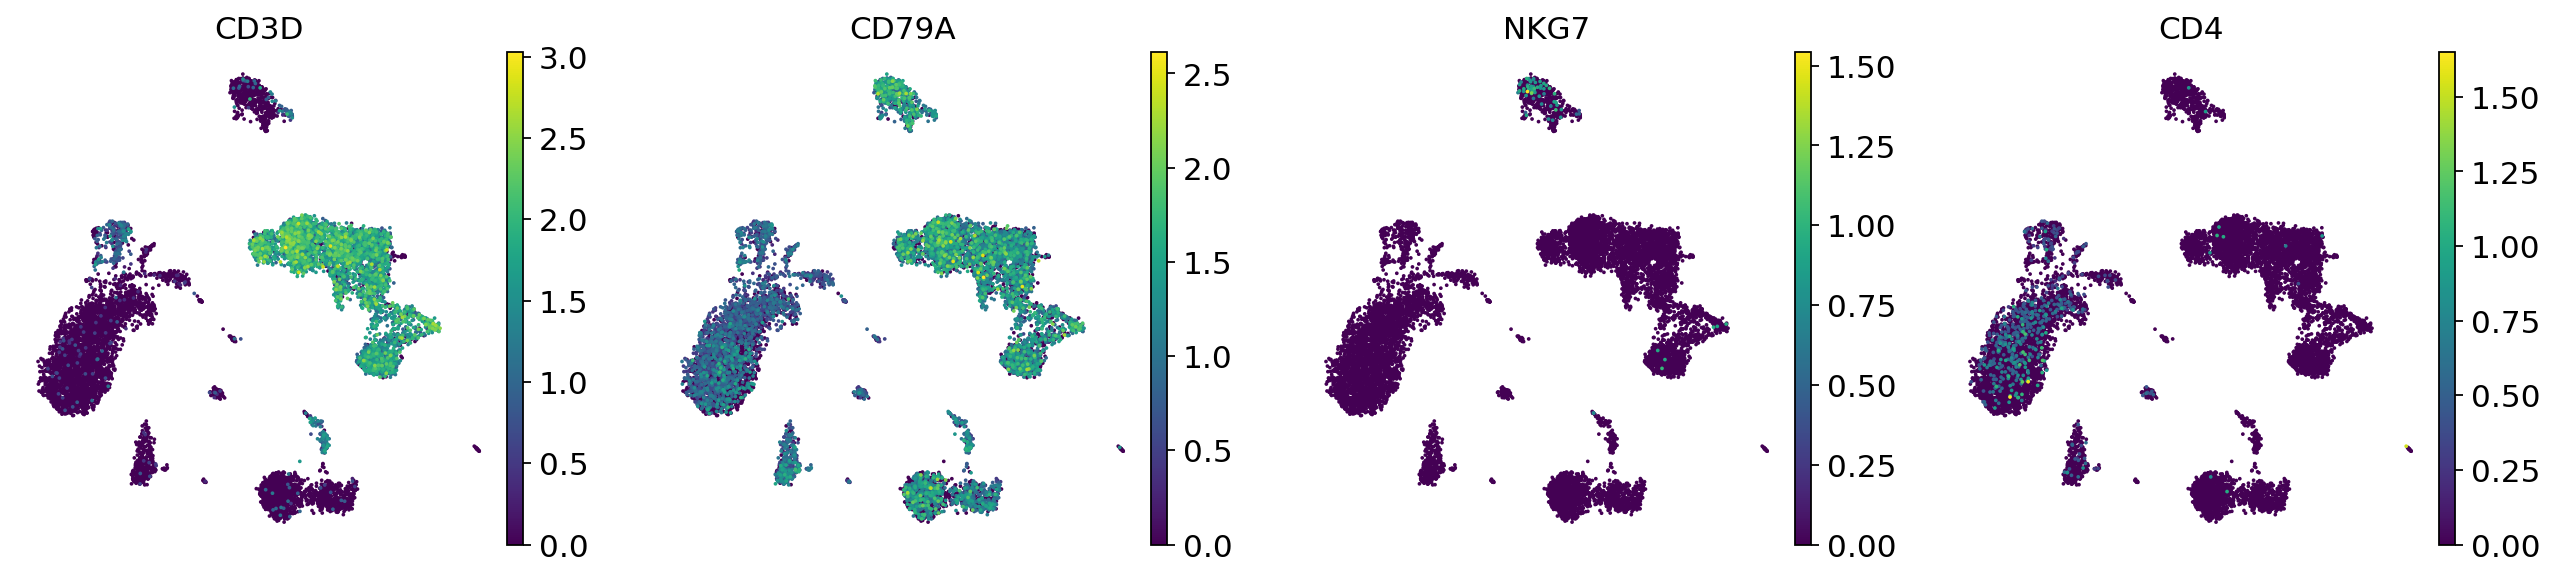

In [47]:
available_genes = [gene for gene in gene_of_interest if gene in adata.var_names]
sc.pl.umap(adata, color=available_genes)

## Spectral Clustering

In [77]:
from sklearn.cluster import SpectralClustering

sc_model = SpectralClustering(n_clusters=12, affinity='nearest_neighbors', n_neighbors=12)
adata.obs['spectral'] = sc_model.fit_predict(adata.obsm['X_pca']).astype(str)

df = pd.DataFrame({
    'Id': adata.obs.index,
    'Label': adata.obs['spectral'].astype(int)
})
df.to_csv('solution_spectral.csv', index=False)

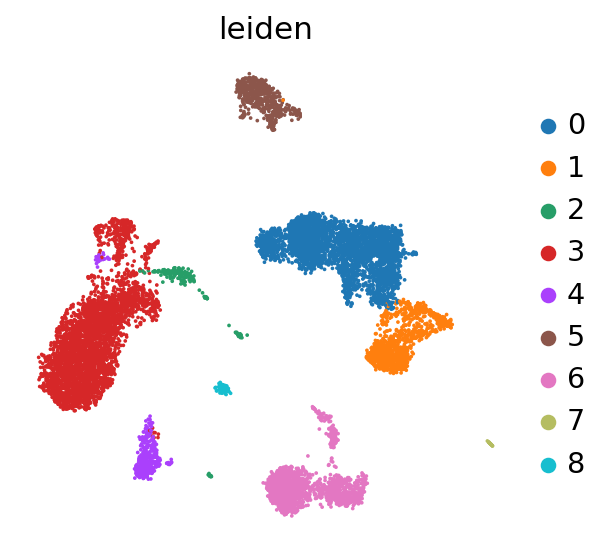

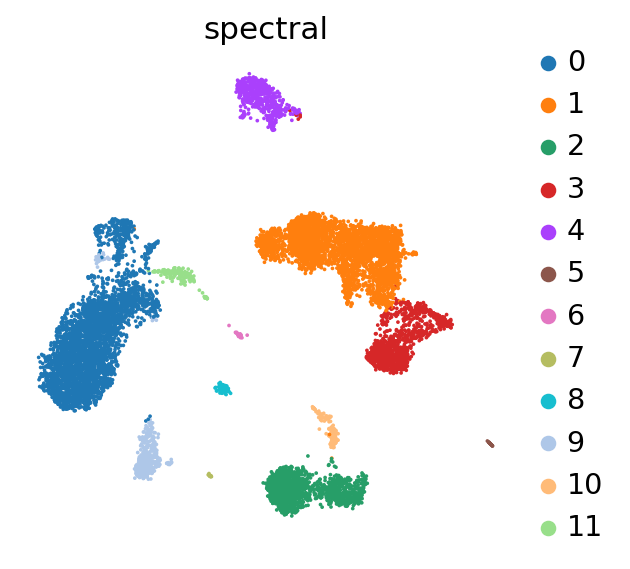

In [79]:
sc.pl.umap(adata, color="leiden")
sc.pl.umap(adata, color="spectral")

# Hierarchical Clustering

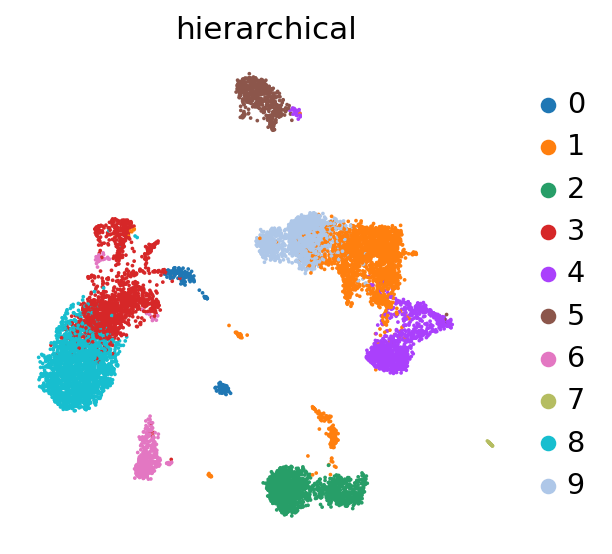

In [80]:
from sklearn.cluster import AgglomerativeClustering

# Perform hierarchical clustering
agg_model = AgglomerativeClustering(n_clusters=10)
adata.obs['hierarchical'] = agg_model.fit_predict(adata.obsm['X_pca']).astype(str)

# Plot the results
sc.pl.umap(adata, color="hierarchical")

# Save the clustering results
df = pd.DataFrame({
    'Id': adata.obs.index,
    'Label': adata.obs['hierarchical'].astype(int)
})
df.to_csv('solution_hierarchical.csv', index=False)